## 심화과제

이번 과제에서는 2023년도 수능 국어 문제를 GPT-4로 풀어볼 것입니다.

#### 환경설정

In [1]:
!pip install openai

In [2]:
from tqdm import tqdm

## 2. 데이터 준비

2023년 수능 국어 문제 데이터를 처리합니다.

In [3]:
import json
import pandas as pd

file_path = './2023_11_KICE.json'

df = pd.read_json(file_path)
df.head()

,id,paragraph,type,problems
0,2023_11_KICE_1-3,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다. 독서의 즐거움에는 여러 ...,0,"[{'question': '윗글의 내용과 일치하지 않는 것은?', 'choices'..."
1,2023_11_KICE_4-9,(가)[A](중국에서 비롯된 유서(類書)는 고금의 서적에서 자료를 수집하고 항목별로...,0,"[{'question': '(가)와 (나)에 대한 설명으로 가장 적절한 것은?', ..."
2,2023_11_KICE_10-13,법령의 조문은 대개 ‘A에 해당하면 B를 해야 한다.’처럼 요건과효과로 구성된 조건...,0,"[{'question': '윗글의 내용과 일치하지 않는 것은?', 'choices'..."
3,2023_11_KICE_14-17,하루에 필요한 에너지의 양은 하루 동안의 총 열량 소모량인 대사량으로 구한다. 그중...,0,"[{'question': '윗글의 내용과 일치하지 않는 것은?', 'choices'..."
4,2023_11_KICE_18-21,혼례를 마친 후 최척이 아내와 함께 장모를 모시고 집으로 돌아오매 하인들이 기뻐했다...,1,"[{'question': '윗글에 대한 설명으로 가장 적절한 것은?', 'choic..."


### 데이터 구조

데이터는 paragraph를 기준으로 해당 지문에 있는 문제들을 list로 가지고 있는 걸 볼 수 있다. 이걸 problems 기준으로 펼쳐줘야 API에 문제를 쏠 때 question 단위로 물어볼 수 있다.

In [4]:
records = []

for _, row in df.iterrows():
    paragraph = row['paragraph']
    for problem in row['problems']:
        record = {
            'paragraph': paragraph,
            'question': problem.get('question'),
            'question_plus': problem.get('question_plus', ''),  # 없을 수 있으니 기본값 ''
            'choices': problem.get('choices'),
            'answer': problem.get('answer'),
            'score': problem.get('score')
        }
        records.append(record)

# 최종 DataFrame 생성
df = pd.DataFrame(records)

# 결과 미리 보기
print(f"문제 개수 : {len(df)}")
df.head()

문제 개수 : 45


,paragraph,question,question_plus,choices,answer,score
0,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다. 독서의 즐거움에는 여러 ...,윗글의 내용과 일치하지 않는 것은?,,"[같은 책을 읽은 독자라도 서로 다른 의미를 구성할 수 있다., 다른 독자와의 소통...",4,2
1,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다. 독서의 즐거움에는 여러 ...,다음은 학생이 독서 후 작성한 글의 일부이다. [A]를 바탕으로 ⓐ～ⓔ를 이해한 내...,ⓐ('음악 시간에 들었던 베토벤의 교향곡 <합창>이 위대한 작품인 이유는 무엇일까?...,"[ⓐ와 ⓑ에는 모두 ‘독자 자신에게서 답을 찾는 질문’이 나타난다., ⓒ와 ⓓ에는 ...",5,3
2,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다. 독서의 즐거움에는 여러 ...,윗글을 읽고 ㉠에 대해 보인 반응으로 적절하지 않은 것은?,,[스스로 독서 계획을 세우고 자신에게 필요한 책을 찾아 개인적으로 읽는 과정에서 경...,1,2
3,(가)[A](중국에서 비롯된 유서(類書)는 고금의 서적에서 자료를 수집하고 항목별로...,(가)와 (나)에 대한 설명으로 가장 적절한 것은?,,"[(가)는 유서의 유형을 분류하였고, (나)는 유서의 분류 기준과적절성 여부를 평가...",4,2
4,(가)[A](중국에서 비롯된 유서(類書)는 고금의 서적에서 자료를 수집하고 항목별로...,[A]에 대한 이해로 적절하지 않은 것은?,,[조선에서 편찬자가 미상인 유서가 많았던 것은 편찬자의 개인적 목적으로 유서를 활용...,5,2


## plot method

* show_prompt_score   
  한 prompt에 대해 여러 model의 score가 있을때 이를 막대그래프로 시각화 해주는 method

In [5]:
def show_prompt_score(prompt_name, yaml_path="prompts.yaml"):
    # YAML 파일 불러오기
    with open(yaml_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)

    if prompt_name not in data or "score" not in data[prompt_name]:
        print(f"'{prompt_name}'에 대한 score 정보가 없습니다.")
        return

    score_data = data[prompt_name]["score"]
    models = list(score_data.keys())
    scores = list(score_data.values())

    # 막대그래프 그리기
    plt.figure(figsize=(8, 5))
    plt.bar(models, scores)
    plt.ylim(0, 100)
    plt.title(f"Model Scores for Prompt: {prompt_name}")
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.grid(axis='y')
    plt.show()

### prompt 적용한 데이터 만들기

question_plus 라는 보기가 제공되는 항목은 필수가 아니기 때문에 prompt의 yaml 파일 구조를 아래와 같이 잡는다.

```yaml
prompt_name:
  description: prompt를 설명하는 문장이 있습니다. (로그용)
  main: |
    기본 prompt가 있습니다.
  plus: |
    question_plus가 있는 prompt가 있습니다.
  score: # 나중에 테스트 후 추가되는 부분
    gpt-4o: 48
    gpt-4o-mini: 30

prompt_name_2: ...
```

그리고 dataframe에 위 prompt를 적용한 prompt라는 column을 만드는 method를 만든다.

In [26]:
import yaml
import matplotlib.pyplot as plt

with open('prompt_v2.yaml','r', encoding='utf-8') as file:
    prompt_templates = yaml.safe_load(file)

In [7]:
def get_prompt_template(prompt_name, yaml_name):
    with open(yaml_name,'r', encoding='utf-8') as file:
        prompt_templates = yaml.safe_load(file)

    print(f"\n{prompt_name} 기반 데이터를 생성하는 중 입니다...\n{prompt_templates[prompt_name]['description']}")

    base = prompt_templates[prompt_name]['main']
    plus = prompt_templates[prompt_name]['plus']
    system = prompt_templates[prompt_name].get('system', "")

    return base, plus, system

In [8]:
def make_data_with_prompt(prompt_name, df, yaml_name):
    base_prompt, plus_prompt, system_prompt = get_prompt_template(prompt_name, yaml_name)

    prompts = []

    for _, row in df.iterrows():
        # choice 가공
        choices = row['choices']
        if isinstance(choices, list):
            choices_str = "\n".join([f"{i+1}. {choice}" for i, choice in enumerate(choices)])
        else:
            choices_str = str(choices)

        # prompt 생성
        if row['question_plus']:
            filled_prompt = plus_prompt.format(
                paragraph=row['paragraph'],
                question_plus=row['question_plus'],
                question=row['question'],
                choices=choices_str
            )
        else:
            filled_prompt = base_prompt.format(
                paragraph=row['paragraph'],
                question=row['question'],
                choices=choices_str
            )

        prompts.append(filled_prompt)

    # 프롬프트 추가
    df['prompt'] = prompts

    return df, system_prompt


## tool

* question_type.json   
문제 유형을 gpt가 판별해준거


In [9]:
import json
from collections import defaultdict

def get_accuracy_by_question_type(prediction_file, type_file):
    # JSON 파일 불러오기
    with open(prediction_file, "r", encoding="utf-8") as f:
        predictions = json.load(f)
    with open(type_file, "r", encoding="utf-8") as f:
        question_types = json.load(f)

    # 문제 유형별 집계용 딕셔너리
    type_stats = defaultdict(lambda: {"correct": 0, "total": 0})

    for idx, result in predictions.items():
        idx_str = str(idx)
        if idx_str not in question_types:
            continue  # 유형 정보 없는 문제는 제외

        q_type = question_types[idx_str]["문제 유형"]
        is_correct = str(result["gpt_pred"]).strip() == str(result["label"]).strip()

        type_stats[q_type]["total"] += 1
        if is_correct:
            type_stats[q_type]["correct"] += 1

    # 결과 출력
    for q_type, stats in type_stats.items():
        acc = stats["correct"] / stats["total"] * 100
        print(f"{q_type}: {stats['correct']} / {stats['total']} ({acc:.1f}%)")


In [10]:
import yaml
import matplotlib.pyplot as plt

def model_acc_all_prompt(model_name, yaml_path="prompts.yaml", save_path=None):
    with open(yaml_path, 'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)

    prompt_scores = []

    for prompt_name, prompt_info in data.items():
        score = prompt_info.get("score", {}).get(model_name, None)
        if score is not None:
            prompt_scores.append((prompt_name, score))
        else:
            print(f"[경고] {prompt_name}에서 '{model_name}'의 score를 찾을 수 없습니다.")

    if not prompt_scores:
        print("✅ 유효한 score 데이터가 없어 시각화를 생략합니다.")
        return

    # 점수 기준 정렬
    prompt_scores.sort(key=lambda x: x[1], reverse=True)
    prompt_names, scores = zip(*prompt_scores)

    # 그래프 생성
    plt.figure(figsize=(8, 5))
    bars = plt.barh(prompt_names, scores, color='cornflowerblue')
    plt.xlabel("Score", fontsize=12)
    plt.title(f"{model_name} Score", fontsize=14)
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()  # 높은 점수가 위에 오도록

    # 점수 표시
    for bar, score in zip(bars, scores):
        plt.text(score + 1, bar.get_y() + bar.get_height()/2,
                 f"{score}", va='center', fontsize=10)

    plt.tight_layout()

    # 저장 또는 출력
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ 그래프가 {save_path}에 저장되었습니다.")
    else:
        plt.show()


### API request

시험 문제를 푸는 것이기 때문에 temperature는 0.0으로 설정

In [11]:
from openai import OpenAI
import os
import time
import re

In [12]:
client = OpenAI(api_key= "")

In [13]:
def query_gpt(user_prompt, system_prompt, model="gpt-4o"):
    try:
        messages = []

        if system_prompt.strip():  # 빈 문자열이 아니면 추가
            messages.append({"role": "system", "content": system_prompt})

        messages.append({"role": "user", "content": user_prompt})

        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("❌ 오류:", e)
        return None

In [14]:
import re

def extract_answer(response_text, prompt_name=None):
    # 우선 순위 1: 한국어 형식 "정답은 2번입니다" 또는 "정답: 2"
    match_ko = re.search(r"정답(?:은|:)?\s*([0-5])\s*(?:번)?(?:입니다)?", response_text)
    if match_ko:
        return match_ko.group(1)

    # 우선 순위 2: 영어 형식 "Answer: 2"
    match_en = re.search(r"Answer:\s*([0-5])", response_text)
    if match_en:
        return match_en.group(1)

    # fallback: 마지막 숫자 0~5 중 하나
    numbers = re.findall(r"\b[0-5]\b", response_text)
    return numbers[-1] if numbers else None


In [15]:
def evaluate_single_prompt(user_prompt: str, system_prompt: str, label: str, idx: int, model: str, score: int, prompt_name: str):
    response = query_gpt(user_prompt, system_prompt, model)

    predicted = extract_answer(response, prompt_name)
    is_correct = (predicted == label)

    result = {
        "system_prompt": system_prompt,
        "prompt": user_prompt,
        "label": label,
        "gpt_output": response,
        "gpt_pred": predicted,
        "is_correct": is_correct,
        "score": score
    }
    return result

In [16]:
def save_results_to_json(results_dict: dict, prompt_name: str, model_name: str):
    """결과를 JSON 파일로 저장"""
    filename = f"{prompt_name}_{model_name}_result.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(results_dict, f, ensure_ascii=False, indent=2)
    print(f"✅ JSON 결과 저장됨: {filename}")

In [17]:
def evaluate_df_with_gpt(df, system_prompt, max_samples=None, sleep_sec=1, prompt_name="base_prompt", model_name="gpt-4o"):
    outputs, preds, corrects = [], [], []
    result_json = {}

    if max_samples:
        df = df.iloc[:max_samples].copy()

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Evaluating ({prompt_name})"):
        user_prompt = row['prompt']
        label = str(row['answer'])

        score = row['score']

        result = evaluate_single_prompt(user_prompt, system_prompt, label, i, model_name, score, prompt_name)

        outputs.append(result["gpt_output"])
        preds.append(result["gpt_pred"])
        corrects.append(result["is_correct"])
        result_json[str(i)] = {
            "prompt": result["prompt"],
            "label": result["label"],
            "gpt_output": result["gpt_output"],
            "gpt_pred": result["gpt_pred"],
            "score": result["score"]
        }

        time.sleep(sleep_sec)

    df["gpt_output"] = outputs
    df["gpt_pred"] = preds
    df["is_correct"] = corrects

    save_results_to_json(result_json, prompt_name, model_name)

    return df

In [18]:
import yaml

class LiteralDumper(yaml.Dumper):
    def represent_scalar(self, tag, value, style=None):

        if isinstance(value, str):
            if '\n' in value:
                style = '|'
            elif '\\n' in value:
                style = '|'
        return super().represent_scalar(tag, value, style)


def update_prompt_accuracy(prompt_name, score, model_name, yaml_path='prompts.yaml'):
    with open(yaml_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)

    if prompt_name in data:
        if "score" not in data[prompt_name]:
            data[prompt_name]["score"] = {}
        data[prompt_name]["score"][model_name] = int(score)

        with open(yaml_path, "w", encoding="utf-8") as f:
            yaml.dump(data, f, allow_unicode=True, sort_keys=False, Dumper=LiteralDumper)

        print(f"✅ {prompt_name} score 저장 완료: {score}")
    else:
        print(f"⚠️ {prompt_name} not found in {yaml_path}")


In [21]:
def solve_problem_with_prompt(prompt_name, init_df, model_name, yaml_name="prompts.yaml", max_len=None):
    # prompt column이 생긴 데이터 프레임 생성
    prompt_df, system_prompt = make_data_with_prompt(prompt_name, init_df, yaml_name)
    result_df = evaluate_df_with_gpt(df = prompt_df, system_prompt=system_prompt, prompt_name = prompt_name, model_name=model_name, max_samples=max_len)

    score = result_df.loc[result_df["is_correct"], "score"].sum()
    print(f"{prompt_name} acc : {score}")

    update_prompt_accuracy(prompt_name, score, model_name, yaml_path=yaml_name)


In [20]:
import yaml

with open('prompts.yaml','r', encoding='utf-8') as file:
    prompt_templates = yaml.safe_load(file)

## prompt 별 실험

### 1. init_prompt 에 대해 model별 평가

init_prompt는 숫자로 답안을 내놓으라는 것 제외하고는 어떠한 지시사항도 없는 prompt이다.   
이를 기본으로 삼아서 여러 모델에 request를 보내봤다.

In [43]:
solve_problem_with_prompt('init_prompt', df, model_name="gpt-4o")


init_prompt 기반 데이터를 생성하는 중 입니다...
아무 prompt 없이 기문 문제 문항만 제시하는 버전입니다.


Evaluating (init_prompt): 100%|██████████| 45/45 [01:22<00:00,  1.82s/it]

✅ JSON 결과 저장됨: init_prompt_gpt-4o_result.json
init_prompt acc : 91
####
91
✅ init_prompt score 저장 완료: 91


In [44]:
solve_problem_with_prompt('init_prompt', df, model_name="gpt-4o-mini")


init_prompt 기반 데이터를 생성하는 중 입니다...
아무 prompt 없이 기문 문제 문항만 제시하는 버전입니다.


Evaluating (init_prompt): 100%|██████████| 45/45 [01:11<00:00,  1.59s/it]

✅ JSON 결과 저장됨: init_prompt_gpt-4o-mini_result.json
init_prompt acc : 58
####
58
✅ init_prompt score 저장 완료: 58


In [45]:
solve_problem_with_prompt('init_prompt', df, model_name="gpt-4.1-mini")


init_prompt 기반 데이터를 생성하는 중 입니다...
아무 prompt 없이 기문 문제 문항만 제시하는 버전입니다.


Evaluating (init_prompt): 100%|██████████| 45/45 [01:12<00:00,  1.62s/it]

✅ JSON 결과 저장됨: init_prompt_gpt-4.1-mini_result.json
init_prompt acc : 83
####
83
✅ init_prompt score 저장 완료: 83


In [46]:
solve_problem_with_prompt('init_prompt', df, model_name="gpt-4.1-nano")


init_prompt 기반 데이터를 생성하는 중 입니다...
아무 prompt 없이 기문 문제 문항만 제시하는 버전입니다.


Evaluating (init_prompt): 100%|██████████| 45/45 [01:07<00:00,  1.50s/it]

✅ JSON 결과 저장됨: init_prompt_gpt-4.1-nano_result.json
init_prompt acc : 44
####
44
✅ init_prompt score 저장 완료: 44


In [34]:
solve_problem_with_prompt('init_prompt', df, model_name="gpt-3.5-turbo")


init_prompt 기반 데이터를 생성하는 중 입니다...
아무 prompt 없이 기문 문제 문항만 제시하는 버전입니다.


Evaluating (init_prompt): 100%|██████████| 45/45 [01:10<00:00,  1.57s/it]

✅ JSON 결과 저장됨: init_prompt_gpt-3.5-turbo_result.json
init_prompt acc : 39
✅ init_prompt score 저장 완료: 39


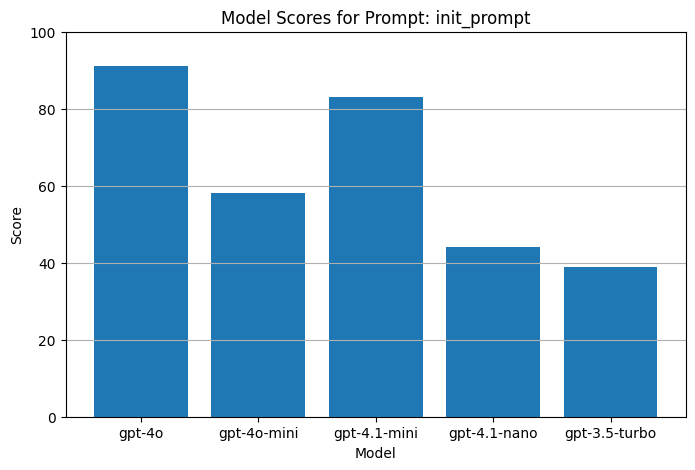

In [35]:
show_prompt_score('init_prompt')

기본 prompt가 gpt-4o 모델로는 성능이 너무 좋았다.

|model|score|
|--|--|
|gpt-4o|91|
|gpt-4o-mini|58|
|gpt-4.1-mini|83|
|gpt-4.1-nano|44|

이미 너무 성능이 좋은 모델이어서인 것 같다.   

이미 과제 목표인 80점은 넘었지만, gpt-4o-mini로 추가 실험을 진행했다.

---

## gpt-4o-mini 기반 테스트

#### 1. **base_prompt**
상황 제시와 기본적인 지침을 준 prompt   

```
아래는 수능 국어 문제입니다.
지문과 질문을 읽고, 스스로 생각한 과정을 적은 뒤 최종 정답을 숫자 하나로 제시하세요.
```

In [21]:
solve_problem_with_prompt('base_prompt', df, model_name="gpt-4o-mini")


base_prompt 기반 데이터를 생성하는 중 입니다...
기본 프롬프트 버전입니다.


Evaluating (base_prompt): 100%|██████████| 45/45 [03:09<00:00,  4.22s/it]

✅ JSON 결과 저장됨: base_prompt_gpt-4o-mini_result.json
base_prompt acc : 60
✅ base_prompt score 저장 완료: 60


**성능 소폭 상승 🔼**   
58(init) -> 60(base)    


#### 2. **CoT_prompt**

```
아래는 수능 국어 문제입니다.
지문과 질문을 읽고, 스스로 생각한 과정을 적은 뒤 최종 정답을 숫자 하나로 제시하세요.
```

단순히 숫자만 내뱉는게 아니라 이유를 작성하면서 답을 유추하도록 수정

In [22]:
solve_problem_with_prompt('CoT_prompt', df, model_name="gpt-4o-mini")


CoT_prompt 기반 데이터를 생성하는 중 입니다...
Chain-of-Thought 기반 추론을 유도하는 국어 문제 프롬프트입니다.


Evaluating (CoT_prompt): 100%|██████████| 45/45 [07:44<00:00, 10.32s/it]

✅ JSON 결과 저장됨: CoT_prompt_gpt-4o-mini_result.json
CoT_prompt acc : 56
✅ CoT_prompt score 저장 완료: 56


[결과]   
**성능 하락 🔽**   
58(init) -> 56(CoT)    

CoT 기법을 넣으면 성능이 올라갈 것으로 예상하였는데, 큰 차이를 보이지 않았다.   
결과 triage 후 그 부분을 보강해서 세부적인 표현을 좀 더 자세히 보도록 지시하는 v2 prompt를 넣었다.

#### 3. **CoT_prompt_v2**

CoT_prompt에서 틀린 답변을 보고 세부적인 지침을 추가한 prompt

```
아래는 수능 국어 문제입니다.
지문과 질문을 읽고, 스스로 생각한 과정을 적은 뒤 최종 정답을 숫자 하나로 제시하세요.

반드시 다음 지침을 따르세요:
1. 각 선택지를 지문의 내용과 정확히 비교하고, 문장 표현이 지문과 완전히 일치하는지 확인하세요.
2. 보기 문장의 의미가 지문의 취지와 다르거나 과도하게 일반화된 경우에도 일치하지 않는 것으로 판단하세요.
3. 지문에서 직접적으로 언급되지 않은 정보는 추측하지 마세요.
4. 모든 선택지를 분석한 뒤, 정답을 숫자 하나로 명확하게 제시하세요.
```

In [23]:
solve_problem_with_prompt('CoT_prompt_v2', df, model_name="gpt-4o-mini")


CoT_prompt_v2 기반 데이터를 생성하는 중 입니다...
Chain-of-Thought 기반 추론을 유도하는 국어 문제 프롬프트입니다.


Evaluating (CoT_prompt_v2): 100%|██████████| 45/45 [07:51<00:00, 10.47s/it]

✅ JSON 결과 저장됨: CoT_prompt_v2_gpt-4o-mini_result.json
CoT_prompt_v2 acc : 68
✅ CoT_prompt_v2 score 저장 완료: 68


**성능 상승 🔼**   
58(init) -> 68(CoT_prompt_v2)

성능이 대폭 오른 것을 확인할 수 있다.  

#### 4. one_shot_prompt   
main : 2025년 국어 수능 문제 1번 문항을 제시해준 prompt   
plus : 2025년 국어 수능 문제 31번 문항을 제시해준 prompt  
prompt별로 한개의 예시를 보여준 뒤 제시되는 문제를 풀도록 하였다.

In [24]:
solve_problem_with_prompt('one_shot_prompt', df, model_name="gpt-4o-mini")


one_shot_prompt 기반 데이터를 생성하는 중 입니다...
Chain-of-Thought 기반으로 한가지 예시를 주는 prompt입니다.


Evaluating (one_shot_prompt): 100%|██████████| 45/45 [05:40<00:00,  7.58s/it]

✅ JSON 결과 저장됨: one_shot_prompt_gpt-4o-mini_result.json
one_shot_prompt acc : 42
✅ one_shot_prompt score 저장 완료: 42


[결과]   
**성능 하락 🔽**   
58(init) -> 42(one-shot)    
문제 유형이 다른데 한가지 유형을 보여줘서 그런가 성능이 오히려 하락했다.

#### 5. translate_prompt

아무래도 영어 성능이 좋을 것 같아 영어로 번역 후에 단계별로 생각하도록 한 prompt

```yaml
다음은 대한민국 수능 국어 문제입니다.
전체 문항(지문, 질문, 선지)을 영어로 번역한 뒤, 영어로 **논리적인 추론 과정을 서술**하고, 최종적으로 정답을 숫자 하나로만 제시하세요.

<지침>
1. 전체 문항(지문, 질문, 선지)을 영어로 정확히 번역하세요.
2. 번역한 영어 지문과 선택지를 바탕으로 문제를 해결하세요.
3. 선택지가 지문과 일부분만 일치하거나, 지문의 의미를 과도하게 일반화하거나 축소했다면 '일치하지 않는 것'으로 판단하세요.
4. **각 선택지에 대해 근거를 바탕으로 판단한 논리적 추론 과정을 간단히 서술하세요.**
5. 모든 선택지를 비교한 후, 반드시 마지막 줄에 **정답을 1~5 중 숫자 하나로만** 적으세요.  
6. 반드시 정답을 하나 고르세요. **답이 명확하지 않더라도 가장 적절한 하나의 선택지를 고르세요.
```


In [25]:
solve_problem_with_prompt('translate_prompt', df, model_name="gpt-4o-mini")


translate_prompt 기반 데이터를 생성하는 중 입니다...
번역하여 생각하길 유도하는 프롬프트입니다.


Evaluating (translate_prompt): 100%|██████████| 45/45 [18:22<00:00, 24.51s/it]

✅ JSON 결과 저장됨: translate_prompt_gpt-4o-mini_result.json
translate_prompt acc : 70
✅ translate_prompt score 저장 완료: 70


[결과]   
**성능 상승 🔼**   
58(init) -> 70(translate)

4o-mini 모델은 영어 성능과 한국어 성능의 차이가 있어서 그런지 영어로 번역하고 학습하라고 했을때 효과가 있었다.

#### 6. translate_prompt_v2/v3

translate의 성능이 좋게 나와 prompt도 영어로 작성하면 더 잘 이해하지 않을까 싶어 translate의 prompt를 번역하여 제시하였다.

```yaml
  This is a Korean CSAT (College Scholastic Ability Test) language question.  
  Please translate the entire content (passage, question, choices) into English, then **write a logical reasoning process in English** and finally present your answer as a single number only.

  <Instructions>  
  1. Translate the entire content (passage, question, choices) into accurate English.  
  2. Solve the question based on the translated passage and choices in English.  
  3. If a choice only partially matches the passage or overgeneralizes/understates the meaning of the passage, consider it as **not matching**.  
  4. **Write a brief logical reasoning for each choice, based on the passage.**  
  5. After comparing all choices, clearly present your final answer as a **single number from 1 to 5 only**.  
  6. You must choose one answer. **Even if the answer is unclear, pick the most appropriate one.**  
  7. At the very end, write the answer in the format: **Answer: [number]**
```

In [33]:
solve_problem_with_prompt('translate_prompt_v2', df, model_name="gpt-4o-mini")


translate_prompt_v2 기반 데이터를 생성하는 중 입니다...
번역하여 생각하길 유도하는 프롬프트 v2입니다.


Evaluating (translate_prompt_v2): 100%|██████████| 45/45 [17:31<00:00, 23.36s/it]

✅ JSON 결과 저장됨: translate_prompt_v2_gpt-4o-mini_result.json
translate_prompt_v2 acc : 60
✅ translate_prompt_v2 score 저장 완료: 60


In [46]:
solve_problem_with_prompt('translate_prompt_v3', df, model_name="gpt-4o-mini")


translate_prompt_v3 기반 데이터를 생성하는 중 입니다...
번역하여 생각하길 유도하는 프롬프트 v3 입니다.


Evaluating (translate_prompt_v3): 100%|██████████| 45/45 [18:06<00:00, 24.14s/it]

✅ JSON 결과 저장됨: translate_prompt_v3_gpt-4o-mini_result.json
translate_prompt_v3 acc : 62
✅ translate_prompt_v3 score 저장 완료: 62


[결과]

translate 대비 **성능 하락 🔽**   
더 추론 과정이 길게 나오는 것 같고 그러면서 성능이 하락되는거 같다.   
아니면 미묘한 한국어의 차이를 무시하게 되는 것 같기도 하다.   

---

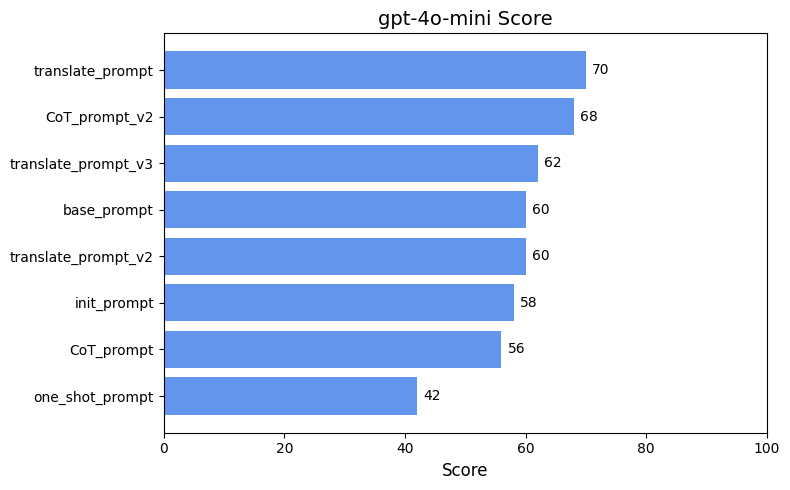

In [55]:
model_acc_all_prompt("gpt-4o-mini")

* gpt-4o-mini 예측
  * 모델이 작아 prompt가 너무 길거나 지시사항이 많으면 역효과가 난다.
  * 모든 유형을 커버할 수 없다면 one shot prompt는 역효과가 될 수 있다.
  * 영어 학습을 상대적으로 더 많이한 모델이라 영어로 생각하게 하는 것이 효과적일 수 있다.

---

### Phase 2

재미로 나무위키에서 국어 수능 1타 강사 목록을 4명 뽑아서 GPT-4.5 모델에게 각 강사가 중요하게 생각하는 풀이 전략을 prompt로 만들어 달라고 했다.

* 메가스터디 강민철
* 이투스 김민정
* 대성아이 김승리
* EBS 윤혜정

teacher_prompt.yaml 파일 참조

#### 1. system prompt 분리

In [27]:
solve_problem_with_prompt('megastudy_prompt', df, model_name="gpt-4o", yaml_name='teacher_prompt.yaml')


megastudy_prompt 기반 데이터를 생성하는 중 입니다...
메가스터디 강민철 선생님 스타일 프롬프트


Evaluating (megastudy_prompt): 100%|██████████| 45/45 [01:43<00:00,  2.30s/it]

✅ JSON 결과 저장됨: megastudy_prompt_gpt-4o_result.json
megastudy_prompt acc : 92
✅ megastudy_prompt score 저장 완료: 92


In [28]:
solve_problem_with_prompt('etoos_prompt', df, model_name="gpt-4o", yaml_name='teacher_prompt.yaml')


etoos_prompt 기반 데이터를 생성하는 중 입니다...
이투스 김민정 선생님 스타일 프롬프트


Evaluating (etoos_prompt): 100%|██████████| 45/45 [01:56<00:00,  2.58s/it]

✅ JSON 결과 저장됨: etoos_prompt_gpt-4o_result.json
etoos_prompt acc : 86
✅ etoos_prompt score 저장 완료: 86


In [29]:
solve_problem_with_prompt('daesung_prompt', df, model_name="gpt-4o", yaml_name='teacher_prompt.yaml')


daesung_prompt 기반 데이터를 생성하는 중 입니다...
대성 김승리 선생님 스타일 프롬프트


Evaluating (daesung_prompt): 100%|██████████| 45/45 [02:21<00:00,  3.14s/it]

✅ JSON 결과 저장됨: daesung_prompt_gpt-4o_result.json
daesung_prompt acc : 82
✅ daesung_prompt score 저장 완료: 82


In [30]:
solve_problem_with_prompt('ebs_prompt', df, model_name="gpt-4o", yaml_name='teacher_prompt.yaml')


ebs_prompt 기반 데이터를 생성하는 중 입니다...
ebs 윤혜 선생님 스타일 프롬프트


Evaluating (ebs_prompt): 100%|██████████| 45/45 [02:18<00:00,  3.07s/it]

✅ JSON 결과 저장됨: ebs_prompt_gpt-4o_result.json
ebs_prompt acc : 90
✅ ebs_prompt score 저장 완료: 90


---
